# PaleoSTeHM: A modern, scalable Spatio-Temporal Hierarchical Modeling framework for paleo-environmental data

Yucheng Lin - yc.lin@rutgers.edu

with Alex Reedy and Robert Kopp

## Analysis Choice Tutorial 
This tutorial about analysis choice includes some relatively advanced content which assumes some basic knowledge about statistics. Although understanding this tutorial will be helpful for better using PaleoSTeHM, it is `not necessary` for everyone to understand the content here about optimization as PaleoSTeHM will provide automatic tool to do that for you.

### Deterministic vs Probablisitic

Analysis choice decisions in how to implement a specific model structure. Generally, we can think a model either to be a deterministic model or a probabilistic (i.e., stochastic) model. And for each type of these model, we apply different analysis choices. 

For a [deterministic method](https://en.wikipedia.org/wiki/Deterministic_algorithm), it assumes given a particular input, this model will always produce the same output, with the underlying machine always passing through the same sequence of states. Typical examples of this type of model include ordinary linear regression, Poisson Regression, ARIMA (AutoRegressive Integrated Moving Average) and neural network.

Alternatively, a [probabilistic model](https://en.wikipedia.org/wiki/Probabilistic_method) presents data and predicts outcomes that account for certain levels of unpredictability or randomness, which are often represented by probablisitic density functions (PDF). Typical examples of this type of model include Bayesian linear regression, Bayesian nerual network and Gaussian Process. 

### Deterministic model analysis choice

#### 1. Least Squares
For deterministic models, there are multiple analysis choices to find a set of parameters that best fit the observation. For models with relatively small to medium amount of parameters (say <1000 parameters), least squares family methods, that minimize the sum of the squared differences between the observed data and the predicted values from the model, is commonly-used. 

Depending on the observational errors, three commonly-used least squares methods are: (1) ordinary least squares (OLS); (2) weighted least squares (WLS) and (3) generalized least squares (GLS). OLS analysis does not include implementation of a data level, and therefore typically excludes explicit measurement and inferential uncertainties. It also assumes errors are independent and identically distributed. 

WLS and GLS are slightly more advanced solutions than OLS, where WLS addresses the problem of heteroscedastic (unequal) variances, and GLS additionally addresses the problem of autocorrelation among variances, both of which are common characteristics of data used in sea-level analyses. In other words, heteroscedastic address the problem that the data quality of some observations maybe better than ohters, hence, least squares will pay more attentions to fit those high-qualtiy data than other low-quality data. The autocorrelation among variances indicate the uncertainties between different data points might correlate with each other, which can be a case for data points from the same sediment core. 

Let's try them out below using sea-level data from Norhtern North Carolina by [Kemp et al., 2011](https://www.pnas.org/doi/abs/10.1073/pnas.1015619108).

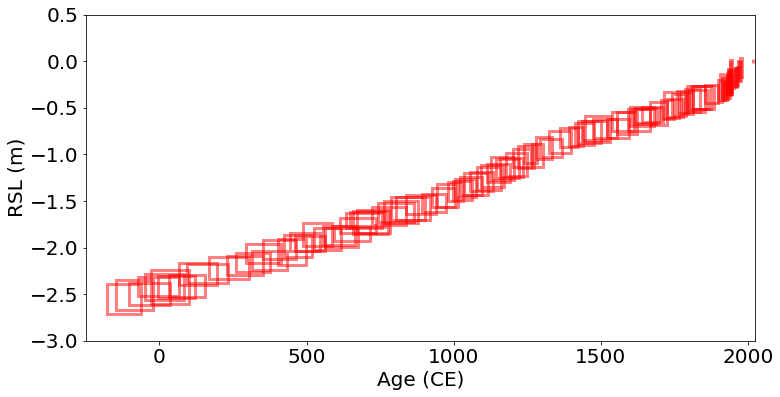

In [2]:
import sys
sys.path.append('../../Code')
import PSTHM 
import numpy as np
import torch 
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import warnings
from scipy import interpolate

warnings.filterwarnings("ignore")
#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)

#load data 
NNC_X,NNC_y,NNC_y_sigma,NNC_x_sigma,NNC_lon,NNC_lat = PSTHM.load_local_rsl_data('../../Data/NNC_CC.csv')

#visualize data
ax = PSTHM.plot_uncertainty_boxes(NNC_X,NNC_y, NNC_x_sigma*2,NNC_y_sigma*2)
ax.set_xlim(-250,2025)
ax.set_ylim(-3,0.5)
plt.show();

OLS sea-level intercept: -2527.346 (mm), sea-level rise rate 1.180 (mm/yr)
WLS sea-level intercept: -2576.616 (mm), sea-level rise rate 1.235 (mm/yr)
GLS sea-level intercept: -2576.616 (mm), sea-level rise rate 1.235 (mm/yr)


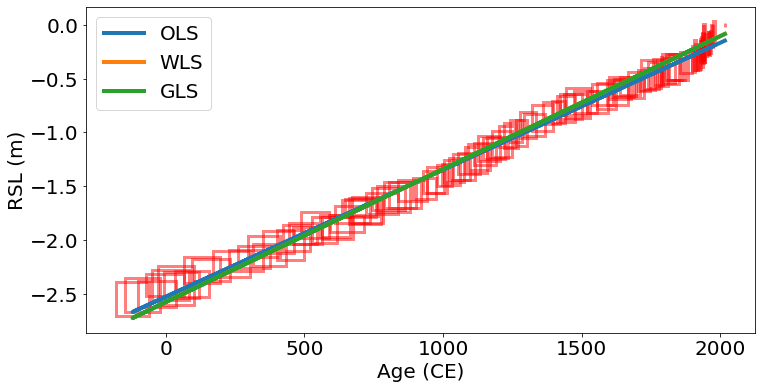

In [4]:
import statsmodels.api as sm
#-----OLS Regression-----
# OLS
X_ols = sm.add_constant(NNC_X)
model_ols = sm.OLS(NNC_y.numpy(), X_ols)
results_ols = model_ols.fit()
print('OLS sea-level intercept: {:3.3f} (mm), sea-level rise rate {:3.3f} (mm/yr)'.format(*results_ols.params *1000))

#-----WLS Regression-----
weights = 1/NNC_y_sigma**2 #where we only consider vertical uncertainty 
model_wls = sm.WLS(NNC_y.numpy(), X_ols, weights=weights)
results_wls = model_wls.fit()
print('WLS sea-level intercept: {:3.3f} (mm), sea-level rise rate {:3.3f} (mm/yr)'.format(*results_wls.params *1000))


#-----GLS Regression-----

cov_struct = np.diag(NNC_y_sigma**2)
model_gls = sm.GLS(NNC_y.numpy(), X_ols, sigma=cov_struct)
results_gls = model_gls.fit()
print('GLS sea-level intercept: {:3.3f} (mm), sea-level rise rate {:3.3f} (mm/yr)'.format(*results_gls.params *1000))

#Visualize the results
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax = PSTHM.plot_uncertainty_boxes(NNC_X,NNC_y, NNC_x_sigma*2,NNC_y_sigma*2)

ax.plot(NNC_X,results_ols.predict(X_ols),label='OLS',lw=4)
ax.plot(NNC_X,results_wls.predict(X_ols),label='WLS',lw=4)
ax.plot(NNC_X,results_gls.predict(X_ols),label='GLS',lw=4)
plt.legend();

 You may find WLS and GLS yields the same results here, this is because we assume the data uncertainty here are independent, meaning uncertainties for different data points being unrelated or not influencing each other in any way. This assumption may not stand to some cases of paleo sea-level data, such as when observational ages are from age-depth modelling of radiocarbon dating. In that case, the age uncertainties of each data point will not be independent. Hence, instead of putting a diagnal covariance matrix (cov_struct variable in the code above; $ \Omega$) like: 

 $$
  \Omega = \begin{pmatrix}
  \sigma y_{1} ^2      & 0     & \cdots  & 0  \\
  0       &   \sigma y_{2}^2      & \cdots  & 0 \\
  \vdots  & \vdots   & \ddots  & \vdots \\
  0       & 0     & \cdots  & \sigma y_{n}^2  \\
\end{pmatrix}
$$
we should calculate the covariance between uncertainty model from each data point:

 $$
  \Omega =\begin{pmatrix}
  \sigma y_{1}^2       & cov(\sigma y_{1} ,\sigma y_{2} )     & \cdots  & cov(\sigma y_{1} ,\sigma y_{n} )  \\
cov(\sigma y_{1} ,\sigma y_{2} )       &   \sigma y_{2} ^2     & \cdots  & cov(\sigma y_{2} ,\sigma y_{n} ) \\
  \vdots  & \vdots   & \ddots  & \vdots \\
  cov(\sigma y_{1} ,\sigma y_{n} )       & cov(\sigma y_{2} ,\sigma y_{n} )    & \cdots  & \sigma y_{n} ^2 \\
\end{pmatrix}
$$

By doing this, GLS will be able to capture the potential correlation between observational uncertainties.

In [35]:
#generate a data model which all data uncertainty are strongly correlated 
data_model = np.zeros((1000,NNC_X.shape[0]))
normal_factor = np.abs(np.random.normal(0,1,1000))
noise = np.random.normal(0,0.005,(NNC_X.shape[0],1000))
for i in range(1000):
    data_model[i] = NNC_y_sigma*normal_factor[i] +noise[:,i]

cov_struct2 = np.cov(data_model.T)
model_gls = sm.GLS(NNC_y.numpy(), X_ols, sigma=cov_struct2)
print('GLS sea-level intercept: {:3.3f} (mm), sea-level rise rate {:3.3f} (mm/yr)'.format(*results_gls.params *1000))


GLS sea-level intercept: -2576.616 (mm), sea-level rise rate 1.235 (mm/yr)


#### 2. Gradient-based optimization

For deterministic models with largr amount of parameters, it can be very slow to perform least squares method due to the large computational resources required to perform matrix operations such as matrix inversion, matrix multiplication. Unlike least square that provides an exact solution of model paramters, gradient-based optimization iteratively update the model parameters to minimize a specified loss function (or cost function), which provides a measure of the model goodness of fit to the data. It starts with an initial guess for the parameter values and iteratively adjusts them based on the gradient from loss function, until converge, each is often regarded as the `learning` process in machine learning field.

<img width=800px src="GD.png"/>

To illustrate, let's try to estimate the linear sea-level rise rate in Northern North Carolina that accounts for heteroscedastic (i.e., equivalent to WLS). In this case, the loss function is:
$$
loss = \frac{1}{N} \sum_{i=1}^{N}(\frac{y_{i}-\hat{y_{i}}}{\sigma y_{i}})^2
$$



Sea-level rise rate: 1.235 (mm/yr)


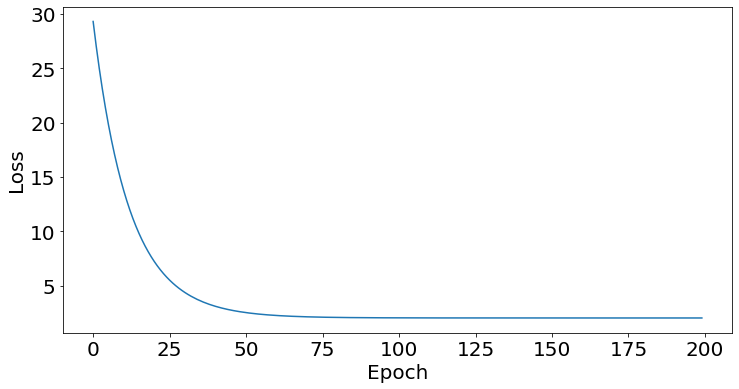

In [350]:
import torch
import torch.nn as nn

# Define the linear regression model
class LinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

# Instantiate the model
input_dim = 1  # Number of input features (independent variables)
output_dim = 1  # Number of output features (dependent variable)
model = LinearRegression(input_dim, output_dim)

# Define loss function and optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)  # Stochastic Gradient Descent optimizer
#normalize the data and the uncertainty
X_norm = (NNC_X.float() - NNC_X.float().mean()) / NNC_X.float().std()
y_norm = (NNC_y.float() - NNC_y.float().mean()) / NNC_y.float().std()
y_sigma_norm = (NNC_y_sigma.float() ) / NNC_y.float().std()
losses = []
# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    # Forward pass
    y_pred = model(X_norm[:,None])

    # Compute loss function
    loss =(((y_pred-y_norm[:,None])/y_sigma_norm[:,None])**2).sum()/len(y_norm)

    # Backward pass and optimization
    optimizer.zero_grad()  # Clear gradients
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights
    losses.append(loss.item())
#calculate the sea-level rise rate
w = model.linear.weight.item()
b = model.linear.bias.item()
y_pred = w * X_norm + b
test_y = (y_pred *NNC_y.float().std() +NNC_y.mean()).detach().numpy()
output_rate = (test_y[2]-test_y[1])/(NNC_X[2]-NNC_X[1])*1000
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
print('Sea-level rise rate: {:3.3f} (mm/yr)'.format(output_rate))

After 1000 epoches of learning, you can find that we got pretty much the same result of sea-level rise rate as WLS, indicating the gradient-based results converge well to find the minimum of loss function. Overall, the choice between least squares and gradient-based optimization depends on specific problem, dataset size, computational resources, and the desired trade-off between accuracy and scalability. Least squares provides an exact solution but may be less scalable and sensitive to outliers. Gradient descent offers more flexibility and scalability but requires tuning of hyperparameters and convergence criteria. You can check [this blog](https://towardsdatascience.com/https-medium-com-chayankathuria-optimization-ordinary-least-squares-gradient-descent-from-scratch-8b48151ba756) to learn more about the pros and cons for them.

If you have gone through our previous tutorials, you should be familiar with the loss function plot above, and you might have a question, why we can get probabilistic estimates of sea-level rise rate with gradient-based optimization in the last tutorial? Isn't it designed for deterministic method? The reason for that is we have used the variational Bayesian method in previous examples, you can check out more details below.

### Probabilistic model analysis choice
There are many probabilistic methods, one popular-choice of them which we will cover there is Bayesian inference that uses Bayes theorem to invert the conditional probability of the observed data and calculate the conditional probability of unknown parameter(s) or process(es). This has been covered in the introduction tutorial. Here we focus on how to infer posterior distribution of unknown parameter(s) and process(es). 

#### 1. Empirical Bayes
Empirical Bayes may be viewed as an approximation to a fully Bayesian treatment of a hierarchical model wherein the parameters at the highest level of the hierarchy are set to their most likely values, instead of being integrated out. The most likely values are often optimized using maximum likelihood estimate, meaning this method yields a posterior distribution of sea level conditional on the data and the optimal parameters. 


In [217]:
import pyro
def linear_model(X, y,x_sigma,y_sigma,intercept_prior,coefficient_prior):
    '''
    A function to define a linear model in pyro 

    ------------Inputs--------------
    X: 2D torch tensor with shape (n_samples,n_features)
    y: 1D torch tensor with shape (n_samples)
    x_sigma: float, standard deviation of the error for age, which is obtained from the age data model
    y_sigma: float, standard deviation of the error for the RSL, which is obtained from the RSL datamodel
    intercept_prior: pyro distribution for the intercept coefficient
    coefficient_prior: pyro distribution for the slope coefficient

    '''
    # Define our intercept prior
    
    linear_combination = pyro.sample("b", intercept_prior)
    #Define our coefficient prior
    
    beta_coef = pyro.sample("a", coefficient_prior)
    #generate random error for age
    N = X.shape[0]
    x_noise = pyro.sample('obs_xerr',dist.Normal(torch.zeros(N),x_sigma).to_event(1))
    x_noisy = X +x_noise
    
    #calculate mean prediction
    mean = linear_combination + ( x_noisy * beta_coef)
    with pyro.plate("data", y.shape[0]):        
        # Condition the expected mean on the observed target y
        observation = pyro.sample("obs", dist.Normal(mean, y_sigma), obs=y)

In [196]:
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

#------Define the process mdoel---------
linear_model = linear_model
test_X = NNC_X[:,None] #convert X to a 2D array which is more common for pytorch models
#-------Define parameter model---------
#you can change the prior distribution here to see how it affects the model!
intercept_prior = dist.Uniform(-5., 0.)
coefficient_prior = dist.Uniform(-0.01,0.01)
#-------Optimize parameter model---------

nuts_kernel = NUTS(linear_model)

mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=10)
mcmc.run(NNC_X,NNC_y,NNC_x_sigma,NNC_y_sigma,intercept_prior,coefficient_prior)
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}



Sample: 100%|██████████| 110/110 [04:23,  2.40s/it, step size=3.12e-05, acc. prob=0.987]


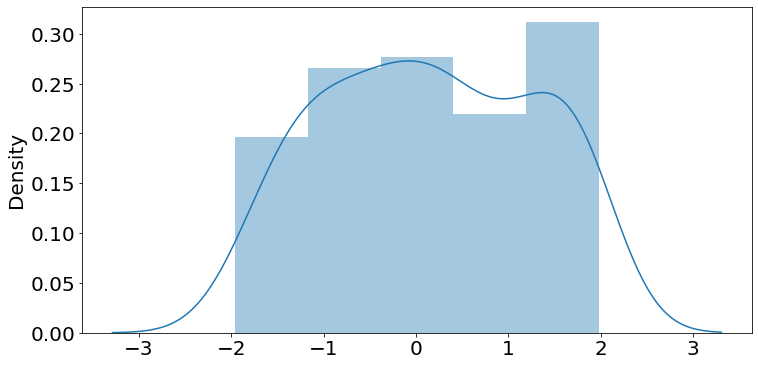

In [194]:
sns.distplot(hmc_samples['obs_xerr'][2])

In [170]:
# guide,losses = PSTHM.opti_pyro_mdoel(linear_model,NNC_X,NNC_y,NNC_x_sigma,NNC_y_sigma,intercept_prior,coefficient_prior,lr=0.02)
guide.quantiles([0.025, 0.5, 0.975])['obs_xerr'][:,10]

tensor([-2.3367,  0.2603,  2.8574])

In [218]:
guide,losses = PSTHM.opti_pyro_mdoel(linear_model,NNC_X,NNC_y,NNC_x_sigma,NNC_y_sigma,intercept_prior,coefficient_prior,lr=0.02)


  0%|          | 0/2000 [00:00<?, ?it/s]

{'b': tensor([-2.6206, -2.5692, -2.5177]),
 'a': tensor([0.0012, 0.0013, 0.0013]),
 'obs_xerr': tensor([[-2.9335e+00, -2.7085e+00, -1.8660e+00, -2.0921e+00, -2.0040e+00,
          -2.0291e+00, -1.9657e+00, -2.9143e+00, -2.9335e+00, -2.7441e+00,
          -2.7619e+00, -3.0229e+00, -3.9310e+00, -4.3988e+00, -4.0864e+00,
          -4.3527e+00, -4.5762e+00, -4.5340e+00, -4.7713e+00, -4.6659e+00,
          -4.5773e+00, -5.6692e+00, -2.2219e+01, -2.9346e+01, -2.8030e+01,
          -2.7856e+01, -2.4810e+01, -2.2151e+01, -1.8929e+01, -1.5566e+01,
          -2.0398e+01, -2.4899e+01, -1.9903e+01, -1.9319e+01, -2.4052e+01,
          -2.4790e+01, -2.4242e+01, -2.3952e+01, -2.5333e+01, -2.7118e+01,
          -2.3982e+01, -2.2170e+01, -2.7677e+01, -2.3181e+01, -2.2211e+01,
          -2.0062e+01, -2.0658e+01, -1.8393e+01, -1.5630e+01, -1.5536e+01,
          -1.8512e+01, -1.9538e+01, -1.6804e+01, -1.2369e+01, -1.3567e+01,
          -1.5867e+01, -1.6689e+01, -2.1683e+01, -2.3450e+01, -2.3809e+01,
     

In [221]:
NNC_x_sigma

tensor([ 1.5000,  1.5000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.5000,
         1.5000,  1.5000,  1.5000,  2.0000,  2.0000,  2.0000,  2.0000,  2.5000,
         2.5000,  2.5000,  2.5000,  2.5000,  2.5000,  3.0000, 11.0000, 17.5000,
        17.5000, 16.5000, 15.0000, 12.5000, 10.0000,  9.0000, 12.0000, 13.5000,
        13.0000, 10.5000, 14.5000, 18.0000, 20.0000, 20.0000, 20.0000, 19.0000,
        17.0000, 18.5000, 19.0000, 20.5000, 21.5000, 21.0000, 19.5000, 16.0000,
        12.0000, 15.0000, 19.0000, 18.5000, 14.0000,  9.5000, 11.0000, 13.0000,
        15.0000, 17.5000, 19.0000, 19.5000, 19.5000, 20.0000, 20.0000, 20.5000,
        20.0000, 20.0000, 19.0000, 17.5000, 16.0000, 13.5000, 18.0000, 19.5000,
        20.5000, 26.0000, 28.5000, 29.5000, 29.5000, 30.0000, 29.0000, 28.0000,
        29.0000, 30.0000, 30.5000, 31.0000, 30.5000, 28.0000, 27.0000, 23.0000,
        25.0000, 26.0000, 26.0000, 24.0000, 24.0000, 28.0000, 29.5000, 29.5000,
        29.0000, 31.0000, 34.0000, 34.50

In [246]:
guide()['obs_xerr']

tensor([ -0.0557,   1.0222,  -0.9300,   0.9245,   0.8478,  -0.4890,   1.2610,
         -0.4022,  -1.6183,   2.2693,  -0.2485,  -0.3969,  -2.5483,  -1.7060,
         -4.4596,  -1.1994,   3.6849,  -2.6323,  -1.1019,  -3.3013,  -0.3863,
         -1.8062, -18.7429, -22.5233, -13.6780, -38.2519,  -2.7918, -16.9394,
        -19.0234,  -6.0485, -16.8955, -24.9858, -31.2078, -24.3101,  -6.8084,
        -46.6424, -31.2287, -36.5619, -25.3159,  11.4371,   1.0632, -15.8385,
        -24.2376, -28.1860, -32.2050, -27.6855, -13.3231,   1.3912, -11.5263,
          5.2243, -16.8565,   7.2697,  -7.7826,  -3.6634,  -1.7753,  -2.9694,
        -17.8278, -25.8764, -42.3875, -23.8846, -19.1252, -21.7506,   6.8611,
        -12.7783, -30.2151, -40.8102,   2.3333,  -4.1648, -25.6844,   5.0857,
        -19.3811, -18.4753, -19.4677, -42.0506, -29.1806, -25.9646,  -9.1753,
         -1.4838, -49.7442, -45.8842, -30.8608, -45.4224, -29.2278, -34.7696,
        -35.0531, -23.6172,  -0.5430, -28.6434,   3.6603, -24.99

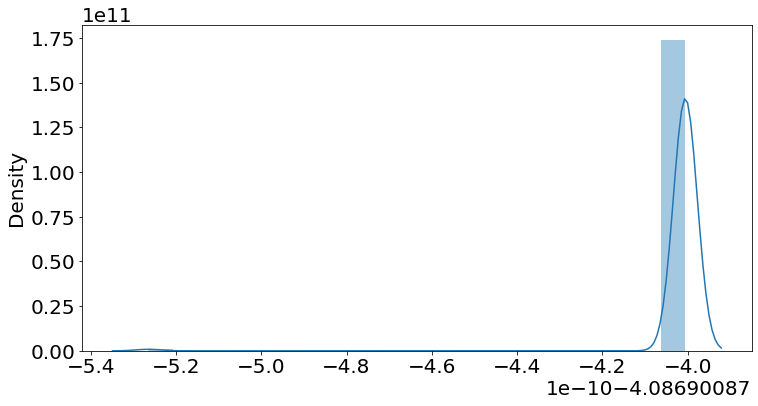

In [128]:
sns.distplot(hmc_samples['b'])

In [106]:
np.unique(hmc_samples['a'])

array([-2.00620561e-06, -1.83821143e-06, -1.79766233e-06, -1.79666975e-06,
       -1.78597972e-06, -1.75176278e-06, -1.71113760e-06, -1.63848794e-06,
       -1.59232769e-06, -1.57966756e-06, -1.47650058e-06, -1.46001762e-06,
       -1.43009617e-06, -1.42223853e-06, -1.39473886e-06, -1.36910983e-06,
       -1.34417178e-06, -1.31546273e-06, -1.31240589e-06, -1.27482816e-06,
       -1.20250625e-06, -1.19550209e-06, -1.19384972e-06, -1.18528019e-06,
       -1.14725585e-06, -1.14544500e-06, -1.11276413e-06, -1.10171070e-06,
       -1.07989264e-06, -1.07530963e-06, -1.04307368e-06, -1.04242025e-06,
       -1.04110570e-06, -1.02352504e-06, -1.00809584e-06, -1.00332138e-06,
       -9.87490325e-07, -9.86410694e-07, -9.86018936e-07, -9.76259298e-07,
       -9.74964548e-07, -9.70979800e-07, -9.69010808e-07, -9.56817631e-07,
       -9.53671268e-07, -9.48636622e-07, -9.41678992e-07, -9.24272795e-07,
       -9.15052758e-07, -9.13557065e-07, -9.04899686e-07, -9.02507161e-07,
       -9.01518993e-07, -